In [1]:
import numpy as np
import matplotlib.pyplot as plt
import taichi as ti

[Taichi] version 1.1.3, llvm 10.0.0, commit 1262a70a, win, python 3.10.5


In [2]:
# KNAPSACK_01 Data for the 01 Knapsack Problem
# P-08 24 elements
capacity = 6404180
optimal = np.asarray([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
                     1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1])

weights = np.asarray([382745, 799601, 909247, 729069, 467902, 44328, 34610, 698150,
                      823460, 903959, 853665, 551830, 610856, 670702, 488960, 951111, 323046, 446298, 931161,
                      31385, 496951, 264724, 224916, 169684])

profits = np.asarray([825594, 1677009, 1676628, 1523970, 943972, 97426, 69666, 1296457,
                      1679693, 1902996, 1844992, 1049289, 1252836, 1319836, 953277, 2067538, 675367, 853655,
                      1826027, 65731, 901489, 577243, 466257, 369261])

In [3]:
optimal_weight = 0
optimal_profit = 0
for i in range(optimal.shape[0]):
    if optimal[i] == 1:
        optimal_weight += weights[i]
        optimal_profit += profits[i]
print("Optimal profit - {}, with weight - {}".format(optimal_profit, optimal_weight))

Optimal profit - 13549094, with weight - 6402560


In [4]:
from Knapsack import KnapsackSettings
from Knapsack import Knapsack
from KnapsackTaichi import KnapsackTaichi

settings = KnapsackSettings(population_size=500, num_objects=weights.shape[0], profits=profits, weights=weights,
                            capacity=capacity, iterations=100, crossover_rate=0.8, mutation_rate=0.2, elitism_num=25)


In [5]:
ti.profiler.clear_kernel_profiler_info()  # clear all records
k = KnapsackTaichi(settings=settings, architecture=ti.cpu, max_num_threads=12)
k.advance()
ti.profiler.print_kernel_profiler_info(mode='count')

[Taichi] Starting on arch=x64
Kernel Profiler(count, default) @ X64 
[      %     total   count |      min       avg       max   ] Kernel name
-------------------------------------------------------------------------
[ 98.59%   0.011 s      1x |   11.451    11.451    11.451 ms] advance_c78_1_kernel_0_serial
[  1.31%   0.000 s      1x |    0.152     0.152     0.152 ms] randomize_population_c80_0_kernel_0_range_for
[  0.07%   0.000 s     24x |    0.000     0.000     0.001 ms] snode_writer_17_kernel_0_serial
[  0.03%   0.000 s     24x |    0.000     0.000     0.001 ms] snode_writer_19_kernel_0_serial
-------------------------------------------------------------------------
[100.00%] Total execution time:   0.012 s   number of results: 4


Text(0, 0.5, 'Profit')

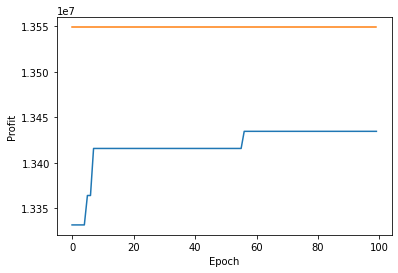

In [6]:
plt.plot(k.history)
plt.plot(np.full(settings.iterations, fill_value=optimal_profit))
plt.xlabel("Epoch")
plt.ylabel("Profit")

Text(0, 0.5, 'Profit')

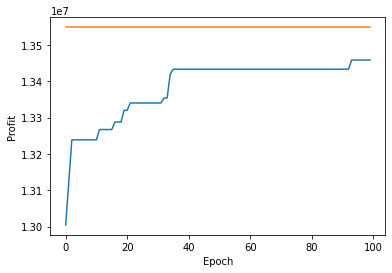

In [7]:
k = Knapsack(settings=settings)
k.advance()
plt.plot(k.history)
plt.plot(np.full(settings.iterations, fill_value=optimal_profit))
plt.xlabel("Epoch")
plt.ylabel("Profit")

In [8]:
import time


def measure_time(di, arch, threads=12) -> list[float]:
    dt = []
    for i in range(len(di)):
        settings.iterations = di[i]
        start = time.time()
        if arch != None:
            k = KnapsackTaichi(settings=settings,
                               architecture=arch, max_num_threads=threads)
        else:
            k = Knapsack(settings=settings)
        k.advance()
        dt.append(time.time() - start)
    return dt

def iterations_per_second(iterations, time) -> float:
    dt = 0
    di = 0
    for i in range(len(iterations) - 1):
        dt += time[i + 1] - time[i]
        di += iterations[i + 1] - iterations[i]
    return di / dt 


In [9]:
iters = [n*100 for n in range(1,3)]
py_perf =  measure_time(iters, None)
ti_gpu_perf =  measure_time(iters, ti.gpu)
ti_cpu_perf =  measure_time(iters, ti.cpu)

[Taichi] Starting on arch=cuda
[Taichi] Starting on arch=cuda
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64


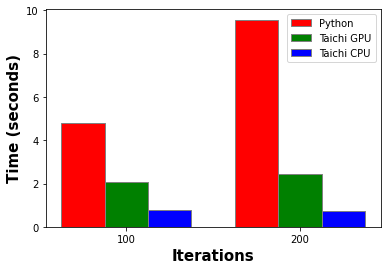

In [10]:
# set width of bar
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(py_perf))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, py_perf, color='r', width=barWidth,
        edgecolor='grey', label='Python')
plt.bar(br2, ti_gpu_perf, color='g', width=barWidth,
        edgecolor='grey', label='Taichi GPU')
plt.bar(br3, ti_cpu_perf, color='b', width=barWidth,
        edgecolor='grey', label='Taichi CPU')

# Adding Xticks
plt.xlabel('Iterations', fontweight='bold', fontsize=15)
plt.ylabel('Time (seconds)', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(py_perf))],
           iters)

plt.legend()
plt.show()


In [11]:
py_ips = iterations_per_second(iters, py_perf)

iters = [n*100 for n in range(1,4)]
py_perf =  measure_time(iters, None)
py_ips = iterations_per_second(iters, py_perf)

# improve accuracy by increasing the tasks complexity
iters_x = [n*1_000 for n in range(1,4)]
ti_gpu_perf =  measure_time(iters_x, ti.gpu)
ti_gpu_ips = iterations_per_second(iters_x, ti_gpu_perf)

iters_xl = [n*10_000 for n in range(1,4)]
ti_cpu_perf =  measure_time(iters_xl, ti.cpu)
ti_cpu_ips = iterations_per_second(iters_xl, ti_cpu_perf)

[Taichi] Starting on arch=cuda
[Taichi] Starting on arch=cuda
[Taichi] Starting on arch=cuda
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64
[Taichi] Starting on arch=x64


In [12]:
data = {'Python': py_ips, 'Taichi GPU': ti_gpu_ips, 'Taichi CPU': ti_cpu_ips}
for key in data:
    print("{} - {:.2f} iterations (epochs) per second".format(key, data[key]))
print()

for key in data:
    print("{} - {:.2f}x faster".format(key, data[key] / py_ips))


Python - 20.95 iterations (epochs) per second
Taichi GPU - 209.76 iterations (epochs) per second
Taichi CPU - 8855.24 iterations (epochs) per second

Python - 1.00x faster
Taichi GPU - 10.01x faster
Taichi CPU - 422.66x faster
